In [2]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 11.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


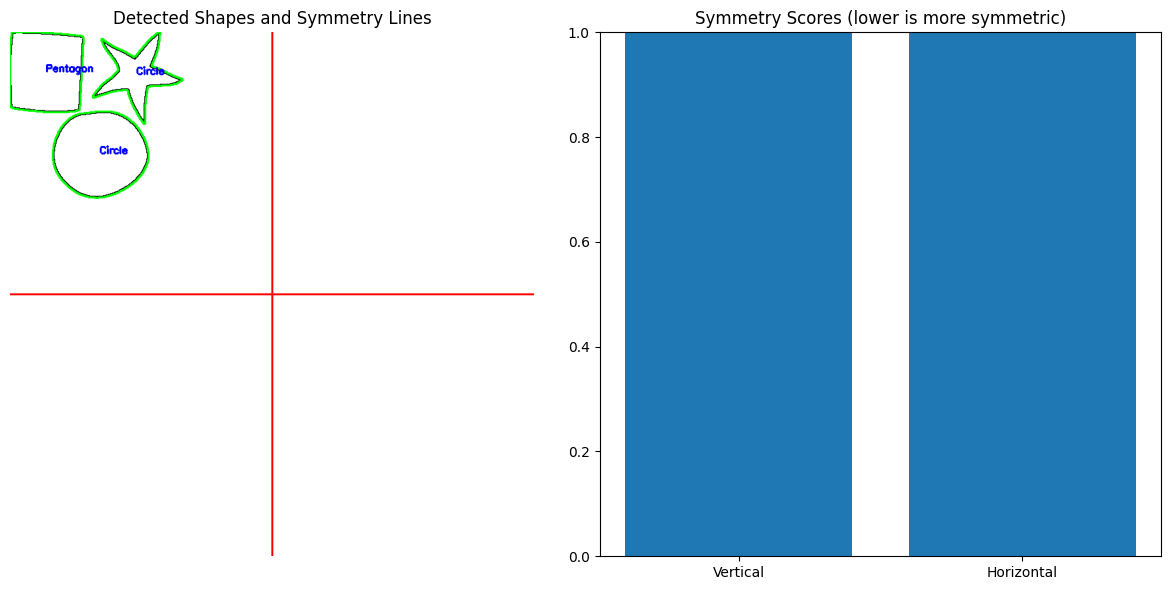

Detected Shapes:
- Circle
- Circle
- Pentagon
Vertical Symmetry Score: 1.8484
Horizontal Symmetry Score: 1.8484


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def create_image_from_polylines(path_XYs, image_size=(800, 800)):
    img = np.ones(image_size + (3,), dtype=np.uint8) * 255
    for shape in path_XYs:
        for path in shape:
            pts = path.astype(np.int32)
            cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 0), thickness=2)
    return img

def detect_shapes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        n_sides = len(approx)

        M = cv2.moments(contour)
        if M['m00'] != 0.0:
            x = int(M['m10'] / M['m00'])
            y = int(M['m01'] / M['m00'])
        else:
            x, y = 0, 0

        if n_sides == 3:
            shape_name = "Triangle"
        elif n_sides == 4:
            shape_name = "Quadrilateral"
        elif n_sides == 5:
            shape_name = "Pentagon"
        elif n_sides == 6:
            shape_name = "Hexagon"
        else:
            shape_name = "Circle"

        shapes.append({"name": shape_name, "contour": contour, "center": (x, y)})

    return shapes

def analyze_symmetry(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Vertical symmetry
    flip_horizontal = cv2.flip(gray, 1)
    vertical_symmetry_score = np.sum(np.abs(gray - flip_horizontal)) / (gray.shape[0] * gray.shape[1])
    
    # Horizontal symmetry
    flip_vertical = cv2.flip(gray, 0)
    horizontal_symmetry_score = np.sum(np.abs(gray - flip_vertical)) / (gray.shape[0] * gray.shape[1])
    
    return vertical_symmetry_score, horizontal_symmetry_score

def visualize_results(img, shapes, v_sym_score, h_sym_score):
    result = img.copy()
    
    for shape in shapes:
        cv2.drawContours(result, [shape["contour"]], 0, (0, 255, 0), 2)
        cv2.putText(result, shape["name"], shape["center"], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    height, width = img.shape[:2]
    cv2.line(result, (width//2, 0), (width//2, height), (0, 0, 255), 2)  # Vertical line
    cv2.line(result, (0, height//2), (width, height//2), (0, 0, 255), 2)  # Horizontal line
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes and Symmetry Lines")
    plt.axis('off')
    
    plt.subplot(122)
    plt.bar(['Vertical', 'Horizontal'], [v_sym_score, h_sym_score])
    plt.title("Symmetry Scores (lower is more symmetric)")
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def process_curvetopia_input(csv_path):
    path_XYs = read_csv(csv_path)
    img = create_image_from_polylines(path_XYs)
    
    shapes = detect_shapes(img)
    v_sym_score, h_sym_score = analyze_symmetry(img)
    
    visualize_results(img, shapes, v_sym_score, h_sym_score)
    
    return shapes, v_sym_score, h_sym_score

# Main execution
if __name__ == "__main__":
    csv_path = "isolated.csv"  # Replace with your actual CSV file path
    shapes, v_sym_score, h_sym_score = process_curvetopia_input(csv_path)
    
    print("Detected Shapes:")
    for shape in shapes:
        print(f"- {shape['name']}")
    print(f"Vertical Symmetry Score: {v_sym_score:.4f}")
    print(f"Horizontal Symmetry Score: {h_sym_score:.4f}")

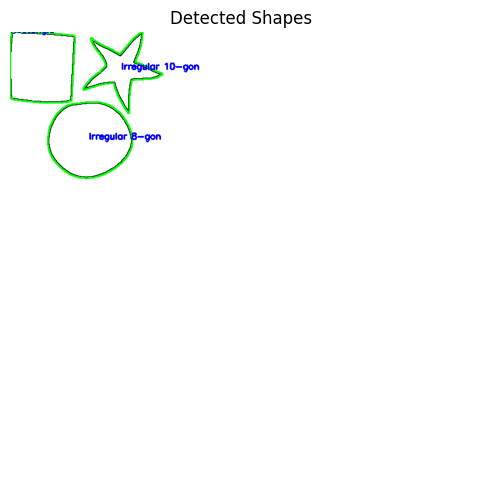

Detected Shapes:
- Irregular 8-gon
- Irregular 10-gon
- Rectangle


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        n_sides = len(approx)

        # Calculate shape features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # Get center of the shape
        M = cv2.moments(contour)
        if M['m00'] != 0.0:
            x = int(M['m10'] / M['m00'])
            y = int(M['m01'] / M['m00'])
        else:
            x, y = 0, 0

        # Classify shape
        if n_sides == 2:
            shape_name = "Straight line"
        elif circularity > 0.9:
            # Further distinguish between circle and ellipse
            (center, axes, angle) = cv2.fitEllipse(contour)
            major, minor = max(axes), min(axes)
            if major / minor < 1.2:  # Adjust this threshold as needed
                shape_name = "Circle"
            else:
                shape_name = "Ellipse"
        elif n_sides == 4:
            # Distinguish between rectangle and rounded rectangle
            x, y, w, h = cv2.boundingRect(contour)
            hull_area = cv2.contourArea(cv2.convexHull(contour))
            solidity = float(area) / hull_area
            if solidity > 0.95:
                shape_name = "Rectangle"
            else:
                shape_name = "Rounded Rectangle"
        elif n_sides >= 5:
            # Check if it's a regular polygon
            angles = []
            for i in range(n_sides):
                pt1 = tuple(approx[i][0])
                pt2 = tuple(approx[(i+1) % n_sides][0])
                pt3 = tuple(approx[(i+2) % n_sides][0])
                angle = np.abs(np.rad2deg(np.arctan2(pt3[1]-pt2[1], pt3[0]-pt2[0]) - np.arctan2(pt1[1]-pt2[1], pt1[0]-pt2[0])))
                angles.append(angle)
            if np.std(angles) < 5:  # Adjust this threshold as needed
                shape_name = f"Regular {n_sides}-gon"
            else:
                shape_name = f"Irregular {n_sides}-gon"
        else:
            # Check for star shape
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = float(area)/hull_area
            if solidity < 0.5:
                shape_name = "Star"
            else:
                shape_name = "Unknown"

        shapes.append({"name": shape_name, "contour": contour, "center": (x, y)})

    return shapes

def visualize_results(img, shapes):
    result = img.copy()
    
    for shape in shapes:
        cv2.drawContours(result, [shape["contour"]], 0, (0, 255, 0), 2)
        cv2.putText(result, shape["name"], shape["center"], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes")
    plt.axis('off')
    plt.show()

def process_curvetopia_input(csv_path):
    path_XYs = read_csv(csv_path)
    img = create_image_from_polylines(path_XYs)
    
    shapes = detect_shapes(img)
    
    visualize_results(img, shapes)
    
    return shapes

# The read_csv and create_image_from_polylines functions remain the same as before

# Main execution
if __name__ == "__main__":
    csv_path = "isolated.csv"  # Replace with your actual CSV file path
    shapes = process_curvetopia_input(csv_path)
    
    print("Detected Shapes:")
    for shape in shapes:
        print(f"- {shape['name']}")

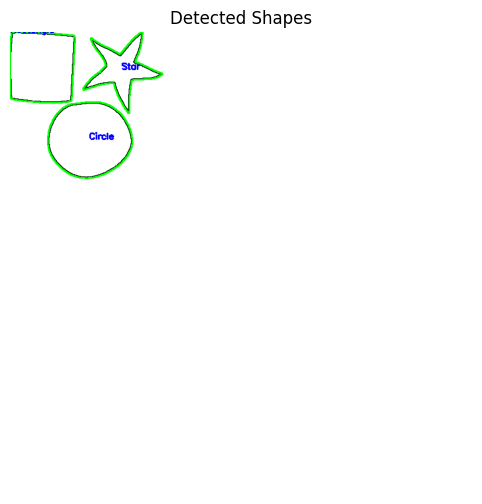

Detected Shapes:
- Circle
- Star
- Rectangle


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        n_sides = len(approx)

        # Calculate shape features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # Get center of the shape
        M = cv2.moments(contour)
        if M['m00'] != 0.0:
            x = int(M['m10'] / M['m00'])
            y = int(M['m01'] / M['m00'])
        else:
            x, y = 0, 0

        # Convexity defects for star detection
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)
        
        # Classify shape
        if n_sides == 2:
            shape_name = "Straight line"
        elif circularity > 0.85:
            # Further distinguish between circle and ellipse
            (center, axes, angle) = cv2.fitEllipse(contour)
            major, minor = max(axes), min(axes)
            if major / minor < 1.2:
                shape_name = "Circle"
            else:
                shape_name = "Ellipse"
        elif n_sides == 4:
            # Distinguish between rectangle and rounded rectangle
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w)/h
            if 0.95 <= aspect_ratio <= 1.05:
                shape_name = "Square"
            else:
                shape_name = "Rectangle"
        elif defects is not None and len(defects) >= 5:
            # Star shape detection
            deep_points = 0
            for i in range(defects.shape[0]):
                s, e, f, d = defects[i, 0]
                if d > 1000:  # you may need to adjust this threshold
                    deep_points += 1
            if deep_points >= 5:
                shape_name = "Star"
            else:
                shape_name = f"Regular {n_sides}-gon"
        elif n_sides >= 5:
            # Check if it's a regular polygon
            angles = []
            for i in range(n_sides):
                pt1 = tuple(approx[i][0])
                pt2 = tuple(approx[(i+1) % n_sides][0])
                pt3 = tuple(approx[(i+2) % n_sides][0])
                angle = np.abs(np.rad2deg(np.arctan2(pt3[1]-pt2[1], pt3[0]-pt2[0]) - np.arctan2(pt1[1]-pt2[1], pt1[0]-pt2[0])))
                angles.append(angle)
            if np.std(angles) < 5:  # Adjust this threshold as needed
                shape_name = f"Regular {n_sides}-gon"
            else:
                shape_name = "Unknown"
        else:
            shape_name = "Unknown"

        shapes.append({"name": shape_name, "contour": contour, "center": (x, y)})

    return shapes

def visualize_results(img, shapes):
    result = img.copy()
    
    for shape in shapes:
        cv2.drawContours(result, [shape["contour"]], 0, (0, 255, 0), 2)
        cv2.putText(result, shape["name"], shape["center"], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes")
    plt.axis('off')
    plt.show()

def process_curvetopia_input(csv_path):
    path_XYs = read_csv(csv_path)
    img = create_image_from_polylines(path_XYs)
    
    shapes = detect_shapes(img)
    
    visualize_results(img, shapes)
    
    return shapes

# The read_csv and create_image_from_polylines functions remain the same as before

# Main execution
if __name__ == "__main__":
    csv_path = "isolated.csv"  # Replace with your actual CSV file path
    shapes = process_curvetopia_input(csv_path)
    
    print("Detected Shapes:")
    for shape in shapes:
        print(f"- {shape['name']}")

/var/folders/tt/2b3cc4b54b349j97hzm_dr740000gn/T/ipykernel_67854/2468739339.py:60: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  B[:, i] = np.math.comb(degree, i) * (t**(i)) * ((1-t)**(degree-i))


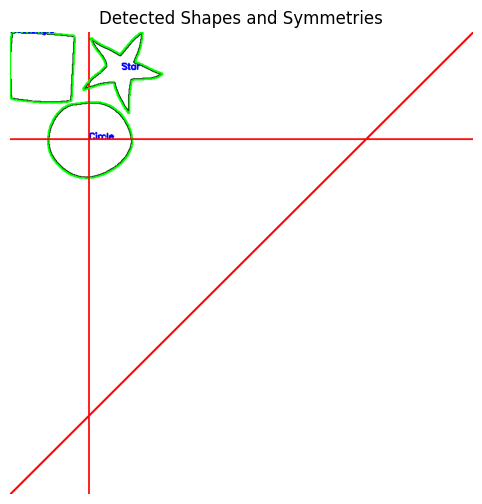

Detected Shapes and Symmetries:
- Circle
  * vertical symmetry (score: 3.29)
  * horizontal symmetry (score: 3.26)
  * diagonal2 symmetry (score: 4.25)
- Star
  * diagonal2 symmetry (score: 4.35)
- Rectangle


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def detect_symmetry(contour, symmetry_types=['vertical', 'horizontal', 'diagonal']):
    """Detect symmetry in a given contour."""
    symmetries = []
    
    # Convert contour to a set of points
    points = contour.reshape(-1, 2)
    
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)
    center = (x + w/2, y + h/2)
    
    def check_symmetry(points, line_func):
        """Check symmetry across a given line."""
        reflected_points = np.array([line_func(p) for p in points])
        distances = cdist(points, reflected_points)
        min_distances = np.min(distances, axis=1)
        return np.mean(min_distances)
    
    # Vertical symmetry
    if 'vertical' in symmetry_types:
        vertical_reflect = lambda p: (2*center[0] - p[0], p[1])
        vertical_score = check_symmetry(points, vertical_reflect)
        if vertical_score < 5:  # Threshold, adjust as needed
            symmetries.append(('vertical', vertical_score))
    
    # Horizontal symmetry
    if 'horizontal' in symmetry_types:
        horizontal_reflect = lambda p: (p[0], 2*center[1] - p[1])
        horizontal_score = check_symmetry(points, horizontal_reflect)
        if horizontal_score < 5:  # Threshold, adjust as needed
            symmetries.append(('horizontal', horizontal_score))
    
    # Diagonal symmetries
    if 'diagonal' in symmetry_types:
        diag1_reflect = lambda p: (2*center[0] - p[1] + center[1], 2*center[1] - p[0] + center[0])
        diag2_reflect = lambda p: (p[1] - center[1] + center[0], p[0] - center[0] + center[1])
        diag1_score = check_symmetry(points, diag1_reflect)
        diag2_score = check_symmetry(points, diag2_reflect)
        if diag1_score < 5:  # Threshold, adjust as needed
            symmetries.append(('diagonal1', diag1_score))
        if diag2_score < 5:  # Threshold, adjust as needed
            symmetries.append(('diagonal2', diag2_score))
    
    return symmetries

def fit_bezier_curve(points, degree=3):
    """Fit a Bézier curve to a set of points."""
    # This is a simplified version. For a more accurate fit, consider using optimization techniques.
    n_points = len(points)
    t = np.linspace(0, 1, n_points)
    
    # Generate the Bernstein matrix
    B = np.zeros((n_points, degree + 1))
    for i in range(degree + 1):
        B[:, i] = np.math.comb(degree, i) * (t**(i)) * ((1-t)**(degree-i))
    
    # Solve for control points
    control_points = np.linalg.lstsq(B, points, rcond=None)[0]
    
    return control_points

def process_curvetopia_input(csv_path):
    path_XYs = read_csv(csv_path)
    img = create_image_from_polylines(path_XYs)
    
    shapes = detect_shapes(img)
    
    for shape in shapes:
        symmetries = detect_symmetry(shape['contour'])
        shape['symmetries'] = symmetries
        
        # Fit Bézier curves to symmetric parts
        if symmetries:
            points = shape['contour'].reshape(-1, 2)
            for sym_type, _ in symmetries:
                if sym_type == 'vertical':
                    left_half = points[points[:, 0] <= shape['center'][0]]
                    right_half = points[points[:, 0] > shape['center'][0]]
                    left_bezier = fit_bezier_curve(left_half)
                    right_bezier = fit_bezier_curve(right_half[::-1])  # Reverse for symmetry
                elif sym_type == 'horizontal':
                    top_half = points[points[:, 1] <= shape['center'][1]]
                    bottom_half = points[points[:, 1] > shape['center'][1]]
                    top_bezier = fit_bezier_curve(top_half)
                    bottom_bezier = fit_bezier_curve(bottom_half[::-1])  # Reverse for symmetry
    
    visualize_results(img, shapes)
    
    return shapes

def visualize_results(img, shapes):
    result = img.copy()
    
    for shape in shapes:
        cv2.drawContours(result, [shape["contour"]], 0, (0, 255, 0), 2)
        cv2.putText(result, shape["name"], shape["center"], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Draw symmetry lines
        if 'symmetries' in shape:
            for sym_type, _ in shape['symmetries']:
                if sym_type == 'vertical':
                    cv2.line(result, (int(shape['center'][0]), 0), (int(shape['center'][0]), img.shape[0]), (0, 0, 255), 2)
                elif sym_type == 'horizontal':
                    cv2.line(result, (0, int(shape['center'][1])), (img.shape[1], int(shape['center'][1])), (0, 0, 255), 2)
                elif sym_type == 'diagonal1':
                    cv2.line(result, (0, 0), (img.shape[1], img.shape[0]), (0, 0, 255), 2)
                elif sym_type == 'diagonal2':
                    cv2.line(result, (img.shape[1], 0), (0, img.shape[0]), (0, 0, 255), 2)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes and Symmetries")
    plt.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    csv_path = "isolated.csv"  # Replace with your actual CSV file path
    shapes = process_curvetopia_input(csv_path)
    
    print("Detected Shapes and Symmetries:")
    for shape in shapes:
        print(f"- {shape['name']}")
        if 'symmetries' in shape:
            for sym_type, score in shape['symmetries']:
                print(f"  * {sym_type} symmetry (score: {score:.2f})")

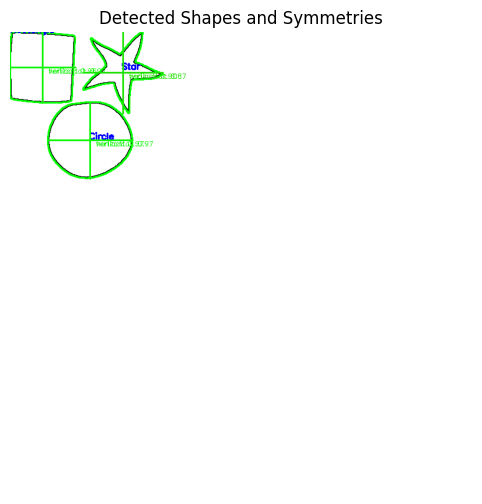

Detected Shapes and Symmetries:
- Circle
  * vertical symmetry (score: 0.97)
  * horizontal symmetry (score: 0.97)
- Star
  * vertical symmetry (score: 0.90)
  * horizontal symmetry (score: 0.87)
- Rectangle
  * vertical symmetry (score: 0.96)
  * horizontal symmetry (score: 0.97)


In [11]:
import numpy as np
import cv2
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter1d

def detect_symmetry(contour, symmetry_types=['vertical', 'horizontal', 'diagonal']):
    """Detect symmetry in a given contour with improved robustness."""
    symmetries = []
    
    # Convert contour to a set of points and smooth it
    points = contour.reshape(-1, 2).astype(float)
    points = smooth_contour(points)
    
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)
    center = np.array([x + w/2, y + h/2])
    
    # Normalize points
    points -= center
    max_dim = max(w, h)
    points /= max_dim
    
    # Create KD-tree for efficient nearest neighbor search
    tree = cKDTree(points)
    
    def check_symmetry(transform_func):
        """Check symmetry using a given transformation function."""
        transformed_points = transform_func(points)
        distances, _ = tree.query(transformed_points)
        return np.mean(distances), np.median(distances), np.std(distances)
    
    # Check symmetries
    symmetry_funcs = {
        'vertical': lambda p: np.array([-p[:, 0], p[:, 1]]).T,
        'horizontal': lambda p: np.array([p[:, 0], -p[:, 1]]).T,
        'diagonal1': lambda p: np.array([-p[:, 1], -p[:, 0]]).T,
        'diagonal2': lambda p: np.array([p[:, 1], p[:, 0]]).T
    }
    
    for sym_type in symmetry_types:
        if sym_type in symmetry_funcs:
            mean_dist, median_dist, std_dist = check_symmetry(symmetry_funcs[sym_type])
            score = calculate_symmetry_score(mean_dist, median_dist, std_dist)
            if score > 0.7:  # Adjust threshold as needed
                symmetries.append((sym_type, score))
    
    return symmetries

def smooth_contour(points, sigma=2):
    """Smooth the contour using Gaussian filter."""
    smoothed = np.zeros_like(points)
    smoothed[:, 0] = gaussian_filter1d(points[:, 0], sigma, mode='wrap')
    smoothed[:, 1] = gaussian_filter1d(points[:, 1], sigma, mode='wrap')
    return smoothed

def calculate_symmetry_score(mean_dist, median_dist, std_dist):
    """Calculate a symmetry score based on distance statistics."""
    base_score = 1 - (mean_dist + median_dist) / 2
    consistency_factor = 1 / (1 + std_dist)
    return base_score * consistency_factor

def visualize_symmetry(img, shapes):
    result = img.copy()
    
    for shape in shapes:
        cv2.drawContours(result, [shape["contour"]], 0, (0, 255, 0), 2)
        cv2.putText(result, shape["name"], shape["center"], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        if 'symmetries' in shape:
            x, y, w, h = cv2.boundingRect(shape["contour"])
            center = (int(x + w/2), int(y + h/2))
            for sym_type, score in shape['symmetries']:
                color = (0, int(255 * score), int(255 * (1 - score)))
                if sym_type == 'vertical':
                    cv2.line(result, (center[0], y), (center[0], y+h), color, 2)
                elif sym_type == 'horizontal':
                    cv2.line(result, (x, center[1]), (x+w, center[1]), color, 2)
                elif sym_type == 'diagonal1':
                    cv2.line(result, (x, y), (x+w, y+h), color, 2)
                elif sym_type == 'diagonal2':
                    cv2.line(result, (x+w, y), (x, y+h), color, 2)
                
                # Display symmetry score
                text_pos = (center[0] + 10, center[1] + 10)
                cv2.putText(result, f"{sym_type}: {score:.2f}", text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    return result

def process_curvetopia_input(csv_path):
    path_XYs = read_csv(csv_path)
    img = create_image_from_polylines(path_XYs)
    
    shapes = detect_shapes(img)
    
    for shape in shapes:
        symmetries = detect_symmetry(shape['contour'])
        shape['symmetries'] = symmetries
    
    result_img = visualize_symmetry(img, shapes)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes and Symmetries")
    plt.axis('off')
    plt.show()
    
    return shapes

# Main execution remains the same as before
if __name__ == "__main__":
    csv_path = "isolated.csv"  # Replace with your actual CSV file path
    shapes = process_curvetopia_input(csv_path)
    
    print("Detected Shapes and Symmetries:")
    for shape in shapes:
        print(f"- {shape['name']}")
        if 'symmetries' in shape:
            for sym_type, score in shape['symmetries']:
                print(f"  * {sym_type} symmetry (score: {score:.2f})")

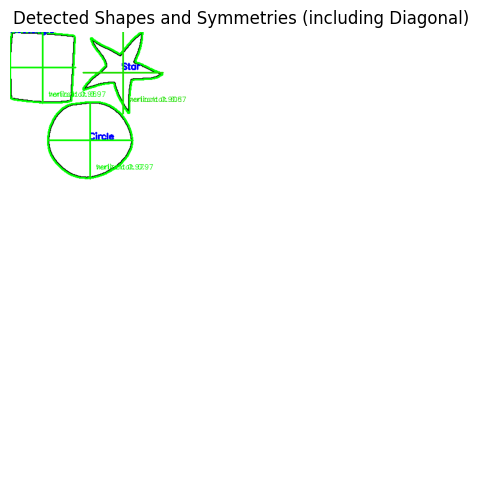

Detected Shapes and Symmetries:
- Circle
  * vertical symmetry (score: 0.97)
  * horizontal symmetry (score: 0.97)
- Star
  * vertical symmetry (score: 0.90)
  * horizontal symmetry (score: 0.87)
- Rectangle
  * vertical symmetry (score: 0.96)
  * horizontal symmetry (score: 0.97)


In [12]:
import numpy as np
import cv2
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

def detect_symmetry(contour, symmetry_types=['vertical', 'horizontal', 'diagonal']):
    """Detect symmetry in a given contour, including diagonal symmetry."""
    symmetries = []
    
    # Convert contour to a set of points and smooth it
    points = contour.reshape(-1, 2).astype(float)
    points = smooth_contour(points)
    
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)
    center = np.array([x + w/2, y + h/2])
    
    # Normalize points
    points -= center
    max_dim = max(w, h)
    points /= max_dim
    
    # Create KD-tree for efficient nearest neighbor search
    tree = cKDTree(points)
    
    def check_symmetry(transform_func):
        """Check symmetry using a given transformation function."""
        transformed_points = transform_func(points)
        distances, _ = tree.query(transformed_points)
        return np.mean(distances), np.median(distances), np.std(distances)
    
    # Check symmetries
    symmetry_funcs = {
        'vertical': lambda p: np.array([-p[:, 0], p[:, 1]]).T,
        'horizontal': lambda p: np.array([p[:, 0], -p[:, 1]]).T,
        'diagonal1': lambda p: np.array([-p[:, 1], -p[:, 0]]).T,  # Top-left to bottom-right
        'diagonal2': lambda p: np.array([p[:, 1], p[:, 0]]).T     # Top-right to bottom-left
    }
    
    for sym_type in symmetry_types:
        if sym_type in symmetry_funcs:
            mean_dist, median_dist, std_dist = check_symmetry(symmetry_funcs[sym_type])
            score = calculate_symmetry_score(mean_dist, median_dist, std_dist)
            if score > 0.7:  # Adjust threshold as needed
                symmetries.append((sym_type, score))
    
    return symmetries

def smooth_contour(points, sigma=2):
    """Smooth the contour using Gaussian filter."""
    smoothed = np.zeros_like(points)
    smoothed[:, 0] = gaussian_filter1d(points[:, 0], sigma, mode='wrap')
    smoothed[:, 1] = gaussian_filter1d(points[:, 1], sigma, mode='wrap')
    return smoothed

def calculate_symmetry_score(mean_dist, median_dist, std_dist):
    """Calculate a symmetry score based on distance statistics."""
    base_score = 1 - (mean_dist + median_dist) / 2
    consistency_factor = 1 / (1 + std_dist)
    return base_score * consistency_factor

def visualize_symmetry(img, shapes):
    result = img.copy()
    
    for shape in shapes:
        cv2.drawContours(result, [shape["contour"]], 0, (0, 255, 0), 2)
        cv2.putText(result, shape["name"], shape["center"], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        if 'symmetries' in shape:
            x, y, w, h = cv2.boundingRect(shape["contour"])
            center = (int(x + w/2), int(y + h/2))
            for sym_type, score in shape['symmetries']:
                color = (0, int(255 * score), int(255 * (1 - score)))
                if sym_type == 'vertical':
                    cv2.line(result, (center[0], y), (center[0], y+h), color, 2)
                elif sym_type == 'horizontal':
                    cv2.line(result, (x, center[1]), (x+w, center[1]), color, 2)
                elif sym_type == 'diagonal1':
                    cv2.line(result, (x, y), (x+w, y+h), color, 2)
                elif sym_type == 'diagonal2':
                    cv2.line(result, (x+w, y), (x, y+h), color, 2)
                
                # Display symmetry score
                text_pos = (center[0] + 10, center[1] + 10 + 20 * len(shape['symmetries']))
                cv2.putText(result, f"{sym_type}: {score:.2f}", text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    return result

def process_curvetopia_input(csv_path):
    path_XYs = read_csv(csv_path)
    img = create_image_from_polylines(path_XYs)
    
    shapes = detect_shapes(img)
    
    for shape in shapes:
        symmetries = detect_symmetry(shape['contour'])
        shape['symmetries'] = symmetries
    
    result_img = visualize_symmetry(img, shapes)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes and Symmetries (including Diagonal)")
    plt.axis('off')
    plt.show()
    
    return shapes

# Main execution
if __name__ == "__main__":
    csv_path = "isolated.csv"  # Replace with your actual CSV file path
    shapes = process_curvetopia_input(csv_path)
    
    print("Detected Shapes and Symmetries:")
    for shape in shapes:
        print(f"- {shape['name']}")
        if 'symmetries' in shape:
            for sym_type, score in shape['symmetries']:
                print(f"  * {sym_type} symmetry (score: {score:.2f})")